# Tame impala song lyrics generation

In [1]:
import json
import re
import string
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
import pickle

## Getting the corpus of song lyrics

In [4]:
file = open("genius_auth.json")
genius_auth = json.load(file)
file.close()

In [5]:
from lyricsgenius import Genius
genius = Genius(genius_auth['client_access_token'],
                verbose=False,
                skip_non_songs=True, 
                excluded_terms=["(Remix)", "(Live)"], 
                remove_section_headers=True)

> The below function automates the removal irrelevant characters and watermarks
>  as best as possible but some instances will require manual pruning

In [38]:
# TESTING PURPOSES
songs = (genius.search_artist(artist_name="Tame Impala")).songs

In [39]:
# Saving the unaltered lyrics
text_file = open("models\\unaltered_lyrics_corpus","w", encoding="utf-8")
for song in songs:
    if not song:
            continue
    song_lryics = song.lyrics
    song_lryics = song_lryics.splitlines()
    for line in song_lryics:
          text_file.write(line+"\n")
text_file.close()

In [6]:
# k is the max no. of songs to get for an artist
def get_lyrics(artist_name, k=None):
    lyrics_corpus = []
    songs = (genius.search_artist(artist_name=artist_name, max_songs=k)).songs
    for song in songs:
        if not song:
            continue
        song_lryics = song.lyrics

        # Removing all punctuation
        song_lryics = song_lryics.replace('[{}]'.format(string.punctuation), '')

        # Making it lowercase
        song_lryics = song_lryics.lower()
        
        # Getting rid of the first line (shows song metadata)
        song_lryics = re.sub(r'\d+.*?lyrics','',song_lryics)
        
        # Removing the watermark in the last line
        song_lryics = re.sub(r'(?:you might also like)?(\d*)embed','',song_lryics)

        # Splitting the lyrics by line
        song_lryics = song_lryics.splitlines()
        
        #Removing empty lines
        song_lryics = list(filter(None, song_lryics))

        # Joining back lines
        song_lryics = '\n'.join(song_lryics)
        # Appending to songs corpus
        lyrics_corpus.append(song_lryics)
    lyrics_corpus = '\n'.join(lyrics_corpus)
    lyrics_corpus = lyrics_corpus.split('\n')
    return lyrics_corpus

In [7]:
lyrics_corpus = get_lyrics("Tame Impala")
lyrics_corpus

['someone said they left together',
 'i ran out the door to get her',
 'she was holding hands with trevor',
 'not the greatest feeling ever',
 'said, "pull yourself together',
 'you should try your luck with heather"',
 'then i heard they slept together',
 'oh, the less i know the better',
 'the less i know the better',
 'oh, my love',
 "can't you see yourself by my side?",
 'no surprise',
 "when you're on his shoulder like every night",
 'oh, my love',
 "can't you see that you're on my mind?",
 "don't suppose you could",
 'convince your lover to change his mind',
 'so goodbye',
 'she said, "it\'s not now or never',
 'wait ten years, we\'ll be together"',
 'i said, "better late than never',
 'just don\'t make me wait forever"',
 "don't make me wait forever",
 "don't make me wait forever",
 'you might also like',
 'oh, my love',
 "can't you see yourself by my side?",
 "i don't suppose you could",
 'convince your lover to change his mind',
 'i was doing fine without ya',
 "till i saw you

## Sequence creation

Checking for list of all unique words in corpus

In [9]:
# Combine all sentences into a single string 
text = ' '.join(lyrics_corpus)

 # Split the text into words 
words = text.split()

 # Create a set to store unique words 
unique_words = set(words)

 # Get the count of unique words 
count_unique_words = len(unique_words)

print("Count of unique words:", count_unique_words)

Count of unique words: 2172


In [10]:
# Making tokenizer with no limit
tokenizer = Tokenizer(num_words=2000)

In [8]:
# Fitting corpus
tokenizer.fit_on_texts(lyrics_corpus)

In [9]:
total_words = tokenizer.num_words
print(total_words)

2000


In [10]:
# Saving tokenizer
with open('tame_impala_tokenizer_mk2.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
#To Load the tokenizer
with open('models\\tame_impala_tokenizer_mk2.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
total_words = tokenizer.num_words


In [12]:
# Converting the corpus into sequences
sequences = []
for line in lyrics_corpus:
    tokenized_line = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(tokenized_line)):
        n_gram_sequence = tokenized_line[:i+1]
        sequences.append(n_gram_sequence)

In [15]:
# Padding sequences
max_sequence_len = max([len(x) for x in sequences])
sequences = np.array(pad_sequences(sequences, 
                                   maxlen=max_sequence_len,
                                   padding = 'pre'))

# Splitting sequences between input and output
# Last element of sequence becomes output
input_sequences, labels = sequences[:,:-1], sequences[:,-1]

# One-hot encoding labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [17]:
# Saving the lyrics in a text file
text_file = open("models\\lyrics_corpus.txt","w", encoding="utf-8")
for item in lyrics_corpus:
    text_file.write(item+"\n")
text_file.close()

## Model creation and training

In [13]:
LSTM_model = Sequential()
LSTM_model.add(Embedding(input_dim=total_words, output_dim=64, input_length=max_sequence_len-1))
LSTM_model.add(Bidirectional(LSTM(20)))
LSTM_model.add(Dense(total_words, activation='softmax'))

In [14]:
LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
LSTM_history = LSTM_model.fit(input_sequences, one_hot_labels, epochs=100)

Epoch 1/100
488/488 [==============================] - 13s 16ms/step - loss: 6.1219 - accuracy: 0.0363
Epoch 2/100
488/488 [==============================] - 7s 15ms/step - loss: 5.7309 - accuracy: 0.0432
Epoch 3/100
488/488 [==============================] - 10s 20ms/step - loss: 5.6046 - accuracy: 0.0493
Epoch 4/100
488/488 [==============================] - 10s 20ms/step - loss: 5.4624 - accuracy: 0.0741
Epoch 5/100
488/488 [==============================] - 10s 20ms/step - loss: 5.3170 - accuracy: 0.0897
Epoch 6/100
488/488 [==============================] - 10s 20ms/step - loss: 5.1743 - accuracy: 0.1010
Epoch 7/100
488/488 [==============================] - 8s 17ms/step - loss: 5.0474 - accuracy: 0.1167
Epoch 8/100
488/488 [==============================] - 8s 17ms/step - loss: 4.9280 - accuracy: 0.1276
Epoch 9/100
488/488 [==============================] - 8s 17ms/step - loss: 4.8078 - accuracy: 0.1480
Epoch 10/100
488/488 [==============================] - 8s 17ms/step - loss: 

In [15]:
LSTM_model.save('LSTM_mk2.h5')

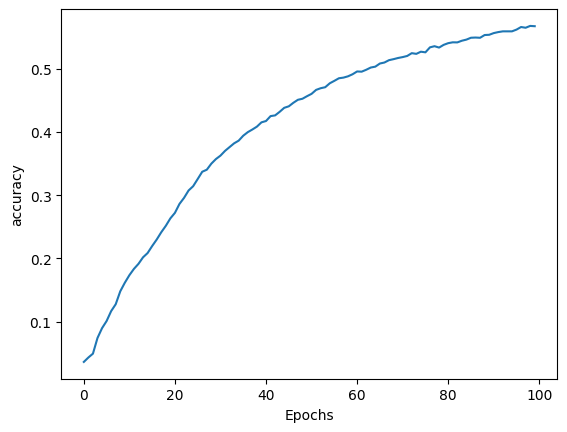

In [16]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(LSTM_history, 'accuracy')

## Generating lyrics

With max probability choice

In [17]:
seed_text = "I close my front door and turn on the light"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(LSTM_model.predict(token_list, verbose=0), axis=-1)

    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

I close my front door and turn on the light oh again one more year midnight with brave pretty second love second decision sun mirrors second toll stuck l summer steps stronger keeps psychiatrists worst heels lose it for pretty lake waves secret composure anyone secret pride almost p horizons arrow hands eyes offer keeps keeps flight keeps keeps keeps keeps case keeps eyes unforgiven keeps day well just loop et keeps day will unforgiven die oh without ya wondering last yine eyes gotta shake soul same good world pride pain and rushing one way older destiny in time zone knows party one more hour one day comes easy yo


In [5]:
from tensorflow.keras.models import load_model
LSTM_model = load_model('LSTM_mk1.h5')

In [12]:
LSTM_model.input_shape[1]

33

With probabilistic choice

In [18]:
seed_text = "I close my front door and turn on the light"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probs = LSTM_model.predict(token_list, verbose=0)[0]
    predicted = np.random.choice([x for x in range(len(predicted_probs))],
                                 p=predicted_probs)
    
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

I close my front door and turn on the light oh with the kept your mind keeps and takin' one more delayin' year warmer started marching happen stuck push push force second face front crazy time and bad so last on a hell on been around for about me while in the day saying even or but in my life oh one day we started saying without track keeps one more year one used white core sweeter p keeps keeps written evening serpentine star couldn't keeps pride eyes keeps pride eyes keeps eyes keeps soul doesn't world prototype devils pain to push keeps hit keeps typing loss sound almost fill


## Saving the input sequences and lables for future use

In [34]:
one_hot_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [33]:
filename = "models\\input_sequences.txt"

# Use numpy.savetxt to save the array to a text file
np.savetxt(filename, input_sequences, fmt='%d', delimiter=', ')

In [36]:
filename = "models\\one_hot_labels.txt"

# Use numpy.savetxt to save the array to a text file
np.savetxt(filename, one_hot_labels, fmt='%d', delimiter=', ')

## Using two LSTM layers

In [20]:
# Using two LSTM layers
double_LSTM_model = Sequential()
double_LSTM_model.add(Embedding(input_dim=total_words, output_dim=64, input_length=max_sequence_len-1))
double_LSTM_model.add(Bidirectional(LSTM(20,return_sequences=True)))
double_LSTM_model.add(Bidirectional(LSTM(20)))
double_LSTM_model.add(Dense(total_words, activation='softmax'))

In [21]:
double_LSTM_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
double_LSTM_history = LSTM_model.fit(input_sequences, one_hot_labels, epochs=100)

Epoch 1/100
488/488 [==============================] - 7s 14ms/step - loss: 5.1022 - accuracy: 0.0950
Epoch 2/100
488/488 [==============================] - 7s 14ms/step - loss: 5.0280 - accuracy: 0.1037
Epoch 3/100
488/488 [==============================] - 8s 16ms/step - loss: 4.9530 - accuracy: 0.1128
Epoch 4/100
488/488 [==============================] - 7s 15ms/step - loss: 4.8739 - accuracy: 0.1217
Epoch 5/100
488/488 [==============================] - 6s 13ms/step - loss: 4.7940 - accuracy: 0.1318
Epoch 6/100
488/488 [==============================] - 7s 14ms/step - loss: 4.7172 - accuracy: 0.1426
Epoch 7/100
488/488 [==============================] - 8s 16ms/step - loss: 4.6473 - accuracy: 0.1484
Epoch 8/100
488/488 [==============================] - 6s 13ms/step - loss: 4.5805 - accuracy: 0.1599
Epoch 9/100
488/488 [==============================] - 7s 13ms/step - loss: 4.5216 - accuracy: 0.1641
Epoch 10/100
488/488 [==============================] - 10s 20ms/step - loss: 4.45

In [22]:
double_LSTM_model.save('models\\double_LSTM_mk1.h5')

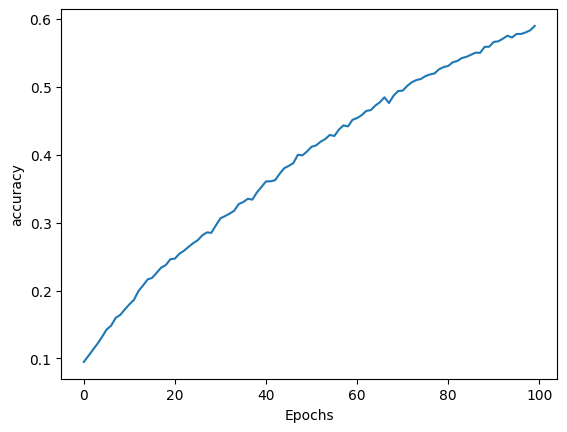

In [23]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(double_LSTM_history, 'accuracy')

In [ ]:
# When testing later
with open('models\\tame_impala_tokenizer_mk2.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
total_words = tokenizer.num_words

from tensorflow.keras.models import load_model
double_LSTM_model = load_model('models\\double_LSTM_mk1.h5')

With max probability choice

In [26]:
seed_text = "I close my front door and turn on the light"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(double_LSTM_model.predict(token_list, verbose=0), axis=-1)

    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

I close my front door and turn on the light invited invited invited desire desire desire desire desire                                                                                            


With probabilistic choice

In [24]:
# Testing the model with np.choice
seed_text = "I close my front door and turn on the light"
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_probs = double_LSTM_model.predict(token_list, verbose=0)[0]
    predicted = np.random.choice([x for x in range(len(predicted_probs))],
                                 p=predicted_probs)
    
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

I close my front door and turn on the light full mum armageddon pouring guessing difference soothing as of all closing greater safe get a home do  starin' broken   doggin' boat çünkü tattoo  kafamın  bit though carin' gruff car before morning phony making mystified divert setting scare huffing since will sweet  tek squalor  chore please move airplane dawns season anyone still  it wasn't love times up  monday holes venture miami admit voices armageddon decision reveals okay eventually today sends found starvation unclear steps weeks surprise us there reach show's end thriving burnin' shuck you  protest plays ready heaven know loop comе quite have been within conscience your care


## Conclusion

The model seems to perform a tad bit better when using two LSTMs but the corpus on which we are training is yet imperfect

Things required whenever training a new model:
- .pickle file of tokenizer
- padded embeddings
  - Alternatively: Separate storage of input sequences and one_hot_labels